# Universal Resistor Color Code Identifier (with Visual)

Run the cell below, then use the interactive UI.

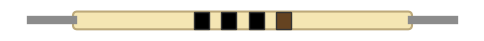

In [6]:
# Universal Resistor Color Code Identifier (with Matplotlib visual)
# -----------------------------------------------------------------
from math import log10, floor
from typing import List, Dict, Tuple, Optional

_CANON = {
    "black": "black","brown": "brown","red": "red","orange": "orange","yellow": "yellow",
    "green": "green","blue": "blue","violet": "violet","purple": "violet",
    "grey": "grey","gray": "grey","white": "white","gold": "gold","silver": "silver","none": "none",
}
DIGIT_COLORS: Dict[str, int] = {"black":0,"brown":1,"red":2,"orange":3,"yellow":4,"green":5,"blue":6,"violet":7,"grey":8,"white":9}
MULTIPLIER_COLORS: Dict[str, float] = {"silver":1e-2,"gold":1e-1,"black":1,"brown":1e1,"red":1e2,"orange":1e3,"yellow":1e4,"green":1e5,"blue":1e6,"violet":1e7,"grey":1e8,"white":1e9}
EXP_TO_COLOR: Dict[int, str] = {-2:"silver",-1:"gold",0:"black",1:"brown",2:"red",3:"orange",4:"yellow",5:"green",6:"blue",7:"violet",8:"grey",9:"white"}
TOLERANCE_COLORS: Dict[str, float] = {"brown":1.0,"red":2.0,"green":0.5,"blue":0.25,"violet":0.1,"grey":0.05,"gold":5.0,"silver":10.0,"none":20.0}
TEMP_COEFF_COLORS: Dict[str, int] = {"black":250,"brown":100,"red":50,"orange":15,"yellow":25,"green":20,"blue":10,"violet":5,"grey":1,"white":1000}
COLOR_HEX: Dict[str, str] = {"black":"#000000","brown":"#654321","red":"#FF0000","orange":"#FFA500","yellow":"#FFFF00",
                              "green":"#008000","blue":"#0000FF","violet":"#8A2BE2","grey":"#808080","white":"#FFFFFF",
                              "gold":"#D4AF37","silver":"#C0C0C0","none":"#F2F2F2"}

def format_ohms(value: float) -> str:
    units=[("GΩ",1e9),("MΩ",1e6),("kΩ",1e3),("Ω",1.0)]
    for u,f in units:
        if value>=f:
            v=value/f
            return f"{v:.4g} {u}"
    return f"{value:.4g} Ω"

def _canon(color: str) -> str:
    c=str(color).strip().lower()
    if c not in _CANON: raise ValueError(f"Unknown color: {color}")
    return _CANON[c]

def colors_to_value(bands: List[str]):
    b=[_canon(x) for x in bands]; n=len(b)
    if n not in (3,4,5,6): raise ValueError("Provide 3, 4, 5, or 6 color bands.")
    if n in (3,4):
        d1,d2=DIGIT_COLORS[b[0]],DIGIT_COLORS[b[1]]; mult=MULTIPLIER_COLORS[b[2]]
        sig=d1*10+d2; ohms=sig*mult; tol=TOLERANCE_COLORS[b[3]] if n==4 else 20.0
        return {"ohms":ohms,"tolerance":tol,"tempco":None}
    d1,d2,d3=DIGIT_COLORS[b[0]],DIGIT_COLORS[b[1]],DIGIT_COLORS[b[2]]; mult=MULTIPLIER_COLORS[b[3]]
    sig=d1*100+d2*10+d3; ohms=sig*mult; tol=TOLERANCE_COLORS[b[4]]; temp=TEMP_COEFF_COLORS[b[5]] if n==6 else None
    return {"ohms":ohms,"tolerance":tol,"tempco":temp}

def _significant_digits(value: float, digits: int):
    if value<=0: raise ValueError("Value must be positive.")
    from math import floor, log10
    exp=int(floor(log10(value))); mant=value/(10**exp); rounded=round(mant,digits-1)
    if rounded>=10.0: rounded/=10.0; exp+=1
    number=int(round(rounded*(10**(digits-1)))); digs=[int(d) for d in str(number).zfill(digits)][:digits]
    mult_exp=exp-(digits-1)
    if mult_exp not in EXP_TO_COLOR: raise ValueError("Value out of supported range (0.01Ω .. 1GΩ).")
    return digs,mult_exp

def value_to_colors(ohms: float, bands: int=4, tolerance: str="gold", tempco: str="brown"):
    if bands not in (3,4,5,6): raise ValueError("bands must be 3, 4, 5, or 6")
    if bands in (3,4):
        digs,mult_exp=_significant_digits(ohms,2)
        colors=[list(DIGIT_COLORS.keys())[list(DIGIT_COLORS.values()).index(digs[0])],
                list(DIGIT_COLORS.keys())[list(DIGIT_COLORS.values()).index(digs[1])],
                EXP_TO_COLOR[mult_exp]]
        if bands==4: colors.append(_canon(tolerance))
        return colors
    digs,mult_exp=_significant_digits(ohms,3)
    colors=[list(DIGIT_COLORS.keys())[list(DIGIT_COLORS.values()).index(digs[0])],
            list(DIGIT_COLORS.keys())[list(DIGIT_COLORS.values()).index(digs[1])],
            list(DIGIT_COLORS.keys())[list(DIGIT_COLORS.values()).index(digs[2])],
            EXP_TO_COLOR[mult_exp], _canon(tolerance)]
    if bands==6: colors.append(_canon(tempco))
    return colors

def describe_colors(bands: List[str]) -> str:
    res=colors_to_value(bands); parts=[f"{format_ohms(res['ohms'])}"]
    if res["tolerance"] is not None: parts.append(f"±{res['tolerance']}%")
    if res["tempco"] is not None: parts.append(f"{res['tempco']} ppm/K")
    return ", ".join(parts)

def draw_resistor(bands: List[str], ax=None, figsize=(6,2)):
    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle, FancyBboxPatch
    cols=[_canon(c) for c in bands]; n=len(cols)
    if ax is None: fig, ax = plt.subplots(figsize=figsize)
    else: fig=ax.figure
    ax.set_aspect('equal'); ax.axis('off')
    lead_y=0.5; body_x0,body_x1=2.0,18.0; body_y0,body_y1=0.1,0.9
    ax.plot([0,body_x0],[lead_y,lead_y],lw=6,color="#8c8c8c")
    ax.plot([body_x1,20],[lead_y,lead_y],lw=6,color="#8c8c8c")
    body=FancyBboxPatch((body_x0,body_y0),body_x1-body_x0,body_y1-body_y0,
                        boxstyle="round,pad=0.02,rounding_size=0.2",
                        linewidth=1.5,edgecolor="#bda97a",facecolor="#F5E6B3")
    ax.add_patch(body)
    left_margin=body_x0+1.2; right_margin=body_x1-1.2; avail_w=right_margin-left_margin
    band_w=0.7; total_w=n*band_w+(n-1)*0.6; start_x=left_margin+(avail_w-total_w)/2
    for i,c in enumerate(cols):
        x=start_x+i*(band_w+0.6); color_hex=COLOR_HEX.get(c,"#000000")
        rect=Rectangle((x,body_y0),band_w,body_y1-body_y0,facecolor=color_hex,edgecolor="#333333",linewidth=1)
        ax.add_patch(rect)
    ax.set_xlim(-1,21); ax.set_ylim(0,1); return fig,ax

def run_cli():
    print("Universal Resistor Color Code Identifier (CLI)")
    print("Choose mode: 1) Colors → Value   2) Value → Colors")
    mode=input("Mode (1/2): ").strip()
    if mode=="1":
        n=int(input("Number of bands (3/4/5/6): ").strip())
        labels={3:["Digit 1","Digit 2","Multiplier"],4:["Digit 1","Digit 2","Multiplier","Tolerance"],
                5:["Digit 1","Digit 2","Digit 3","Multiplier","Tolerance"],
                6:["Digit 1","Digit 2","Digit 3","Multiplier","Tolerance","Temp Coeff"]}[n]
        b=[]; print("Enter colors (red, green, gold, silver, none). 'violet/purple' and 'grey/gray' OK.")
        for lab in labels: b.append(input(f"{lab}: ").strip().lower())
        print("\nResult:", describe_colors(b))
        try: fig,_=draw_resistor(b); import matplotlib.pyplot as plt; plt.show()
        except Exception: pass
    else:
        ohms=float(input("Target resistance in ohms (e.g., 33000): ").strip())
        bands=int(input("Bands (3/4/5/6): ").strip())
        tol="none" if bands==3 else input("Tolerance color: ").strip()
        tco="brown";
        if bands==6: tco=input("Tempco color: ").strip()
        cols=value_to_colors(ohms,bands=bands,tolerance=tol,tempco=tco)
        print("Bands:", cols); print("Meaning:", describe_colors(cols))
        try: fig,_=draw_resistor(cols); import matplotlib.pyplot as plt; plt.show()
        except Exception: pass

def launch_widgets():
    try:
        import ipywidgets as widgets
        from IPython.display import display, Markdown, clear_output
        import matplotlib.pyplot as plt
    except Exception as e:
        print("ipywidgets not available:", e); return
    DIGIT_OPTS=["black","brown","red","orange","yellow","green","blue","violet","grey","white"]
    MULT_OPTS=DIGIT_OPTS+["gold","silver"]
    TOL_OPTS=["brown","red","green","blue","violet","grey","gold","silver","none"]
    TEMP_OPTS=["black","brown","red","orange","yellow","green","blue","violet","grey","white"]
    mode=widgets.ToggleButtons(options=["Colors → Value","Value → Colors"],description="Mode:",value="Colors → Value")
    bands_dd=widgets.Dropdown(options=[3,4,5,6],value=4,description="Bands:")
    out=widgets.Output(); band_pickers=[]
    def make_picker(desc,opts): return widgets.Dropdown(options=opts,description=desc,value=opts[0])
    def rebuild_pickers(*args):
        nonlocal band_pickers
        with out: clear_output()
        band_pickers=[]
        if mode.value=="Colors → Value":
            n=bands_dd.value
            if n==3: labels_opts=[("Digit 1",DIGIT_OPTS),("Digit 2",DIGIT_OPTS),("Multiplier",MULT_OPTS)]
            elif n==4: labels_opts=[("Digit 1",DIGIT_OPTS),("Digit 2",DIGIT_OPTS),("Multiplier",MULT_OPTS),("Tolerance",TOL_OPTS)]
            elif n==5: labels_opts=[("Hundreds",DIGIT_OPTS),("Tens",DIGIT_OPTS),("Ones",DIGIT_OPTS),("Multiplier",MULT_OPTS),("Tolerance",TOL_OPTS)]
            else: labels_opts=[("Hundreds",DIGIT_OPTS),("Tens",DIGIT_OPTS),("Ones",DIGIT_OPTS),("Multiplier",MULT_OPTS),("Tolerance",TOL_OPTS),("TempCoeff",TEMP_OPTS)]
            for lab,opts in labels_opts: band_pickers.append(make_picker(lab,opts))
        else:
            value_box=widgets.FloatText(value=1000.0,description="Ohms:",step=1.0)
            tol_dd=widgets.Dropdown(options=TOL_OPTS,value="gold",description="Tolerance:")
            temp_dd=widgets.Dropdown(options=TEMP_OPTS,value="brown",description="TempCoeff:")
            band_pickers=[value_box,tol_dd,temp_dd]
        refresh_result()
        rows=widgets.VBox([widgets.HBox(band_pickers[i:i+3]) for i in range(0,len(band_pickers),3)])
        ui=widgets.VBox([mode,bands_dd,rows,out]); display(ui)
    def refresh_result(*args):
        with out:
            clear_output()
            try:
                if mode.value=="Colors → Value":
                    cols=[w.value for w in band_pickers]; d=colors_to_value(cols)
                    display(Markdown(f"**Result:** {format_ohms(d['ohms'])}"+(f"\\, ±{d['tolerance']}%" if d['tolerance'] is not None else "")+(f", {d['tempco']} ppm/K" if d['tempco'] is not None else "")))
                    display(Markdown(f"Bands: `{cols}`"))
                    fig,_=draw_resistor(cols); display(fig)
                else:
                    ohms=band_pickers[0].value; tol="none" if bands_dd.value==3 else band_pickers[1].value
                    tco=band_pickers[2].value if bands_dd.value==6 else "brown"
                    cols=value_to_colors(ohms,bands=bands_dd.value,tolerance=tol,tempco=tco)
                    display(Markdown(f"**Bands:** `{cols}`")); display(Markdown(f"Meaning: {describe_colors(cols)}"))
                    fig,_=draw_resistor(cols); display(fig)
            except Exception as e:
                display(Markdown(f"**Error:** {e}"))
    mode.observe(rebuild_pickers,names="value"); bands_dd.observe(rebuild_pickers,names="value")
    def attach_observers():
        for w in band_pickers: w.observe(refresh_result,names="value")
    def first_build(*args):
        rebuild_pickers(); attach_observers()
    first_build();
    def on_displayed(change=None): attach_observers()
    return
launch_widgets()